In [26]:
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from collections import Counter # Used by evaluate_problem_self_consistency_v3
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## For Ties Select the 1st Reported Answer

Looking for files in directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus

Processing file: pass_consensus/seed0_pass_consensus.json (Seed s0)
  DataFrame for seed s0 saved to: pass_consensus/self_consistency_analysis_s0.csv

Processing file: pass_consensus/seed1_pass_consensus.json (Seed s1)
  DataFrame for seed s1 saved to: pass_consensus/self_consistency_analysis_s1.csv

Processing file: pass_consensus/seed2_pass_consensus.json (Seed s2)
  DataFrame for seed s2 saved to: pass_consensus/self_consistency_analysis_s2.csv

Processing file: pass_consensus/seed3_pass_consensus.json (Seed s3)
  DataFrame for seed s3 saved to: pass_consensus/self_consistency_analysis_s3.csv

Total problems processed into Overall DataFrame: 240


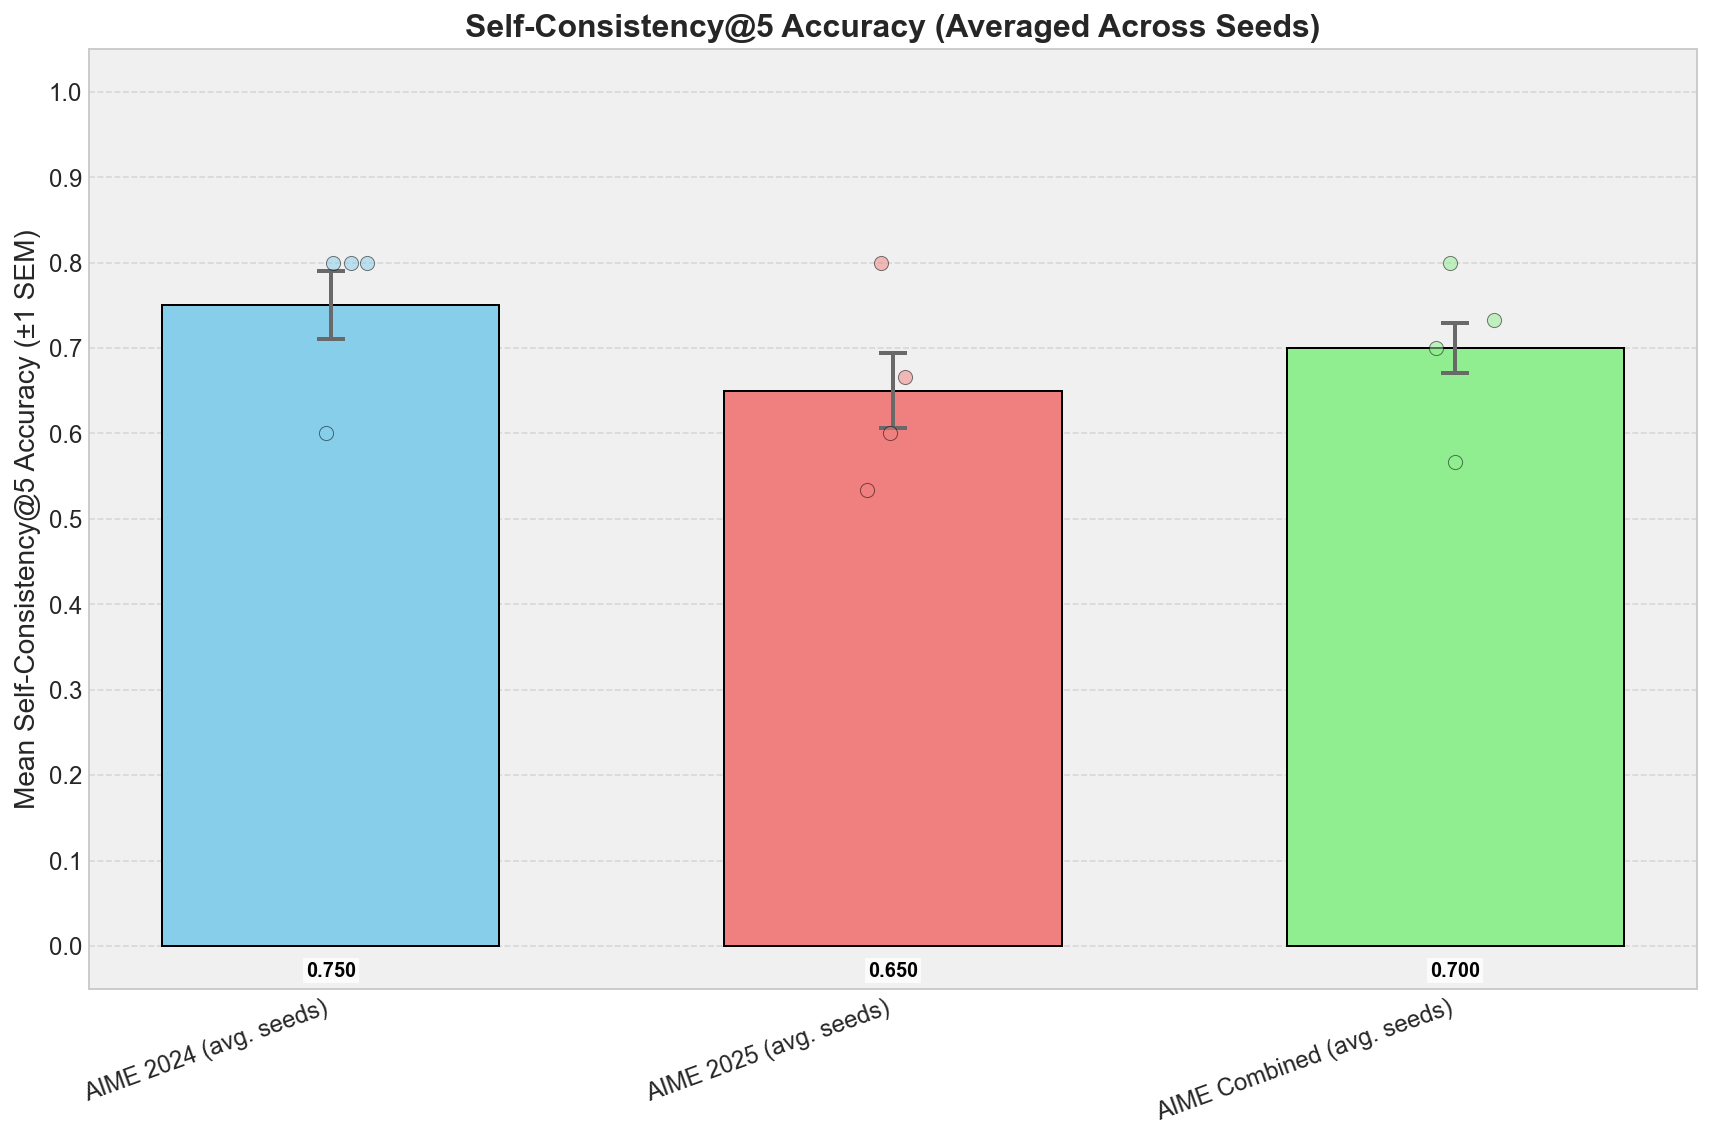


--- Plotted Statistics (Averaged Across Seeds) ---
  AIME 2024 (avg. seeds): Mean = 0.750, SEM = 0.040
  AIME 2025 (avg. seeds): Mean = 0.650, SEM = 0.044
  AIME Combined (avg. seeds): Mean = 0.700, SEM = 0.030

--- Generating Plot for Seed s0 ---


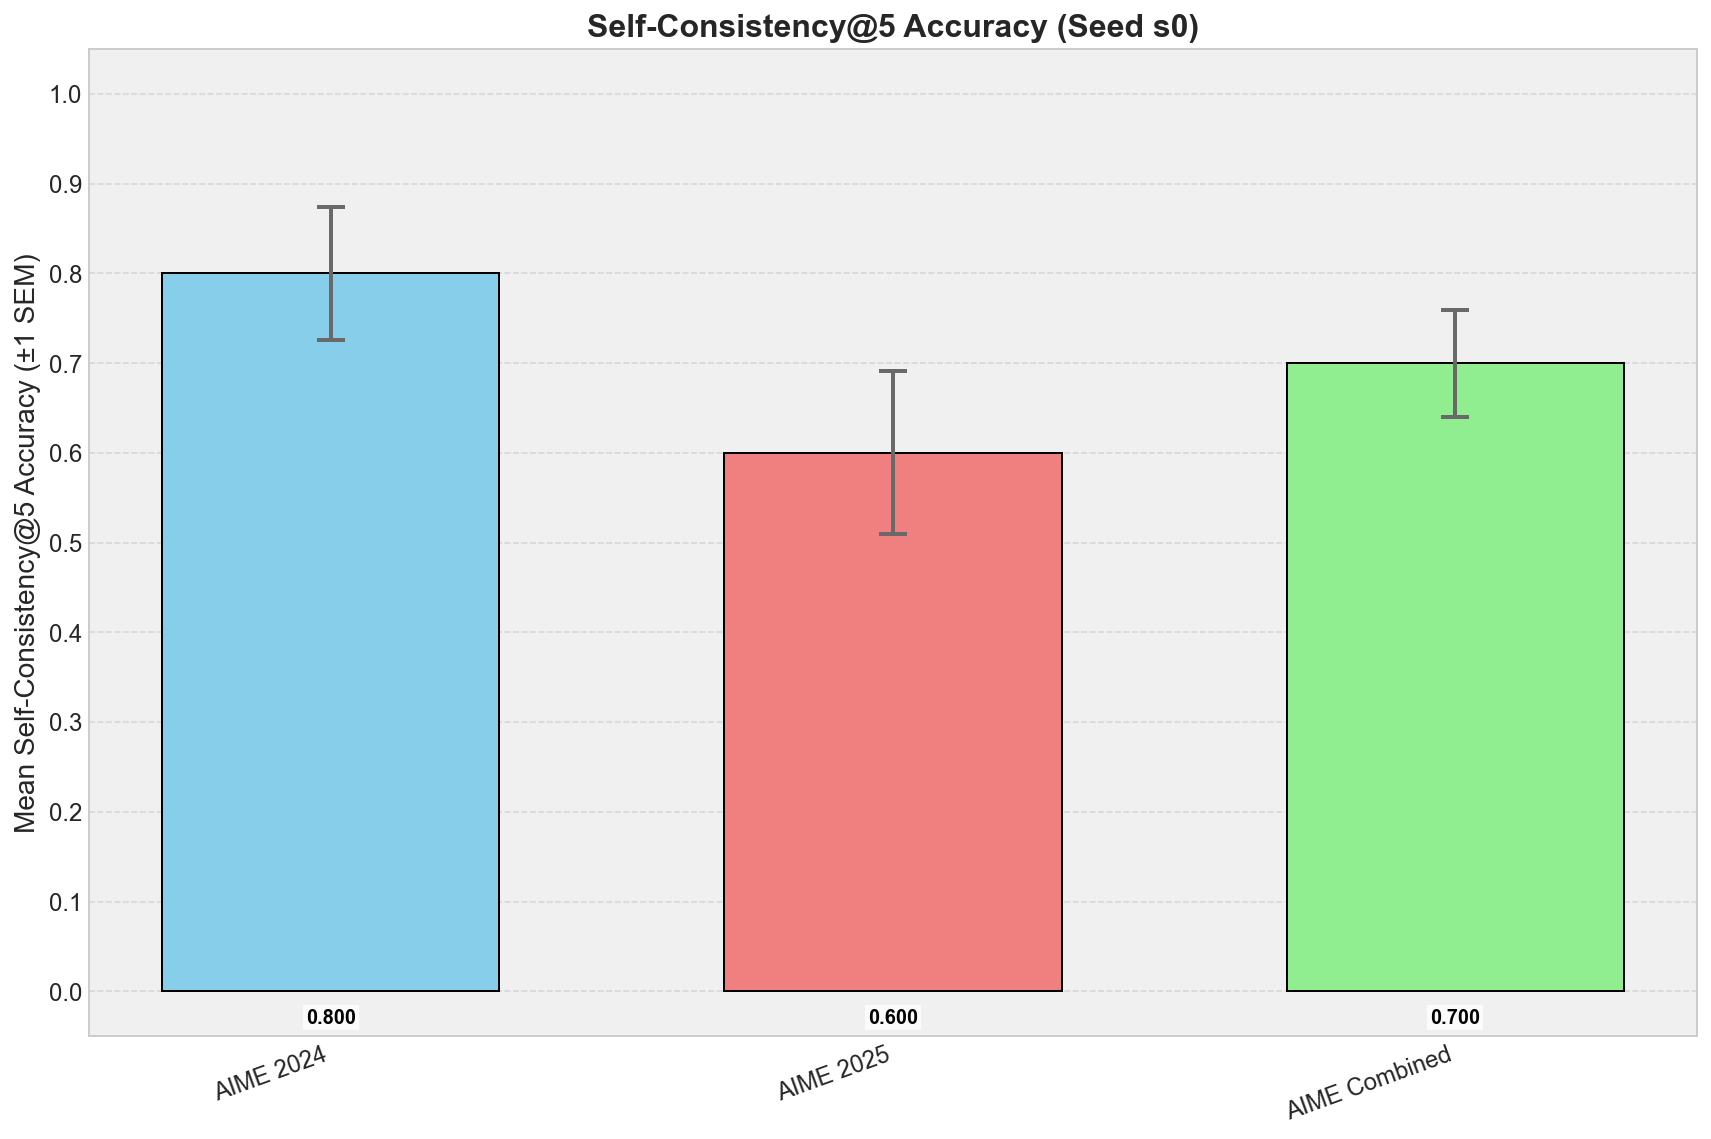


--- Plotted Statistics (Seed s0) ---
  AIME 2024: Mean = 0.800, SEM = 0.074
  AIME 2025: Mean = 0.600, SEM = 0.091
  AIME Combined: Mean = 0.700, SEM = 0.060

--- Generating Plot for Seed s1 ---


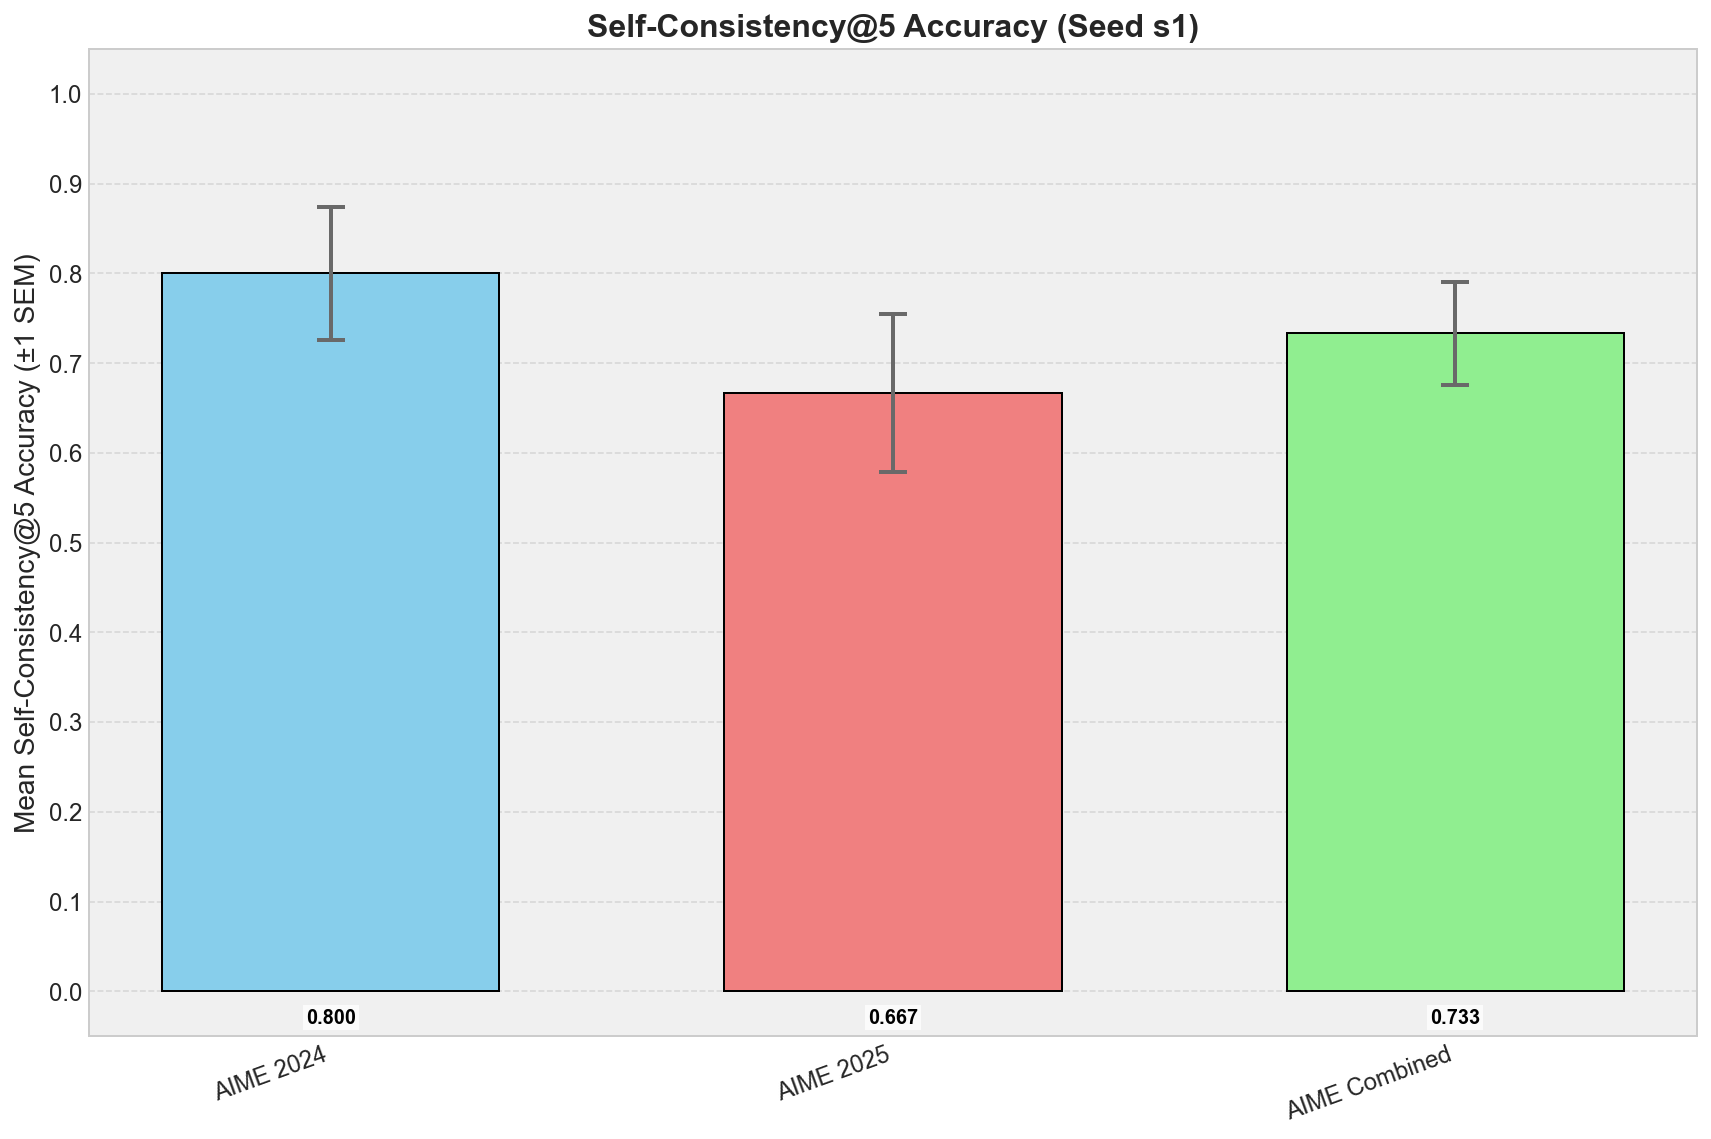


--- Plotted Statistics (Seed s1) ---
  AIME 2024: Mean = 0.800, SEM = 0.074
  AIME 2025: Mean = 0.667, SEM = 0.088
  AIME Combined: Mean = 0.733, SEM = 0.058

--- Generating Plot for Seed s2 ---


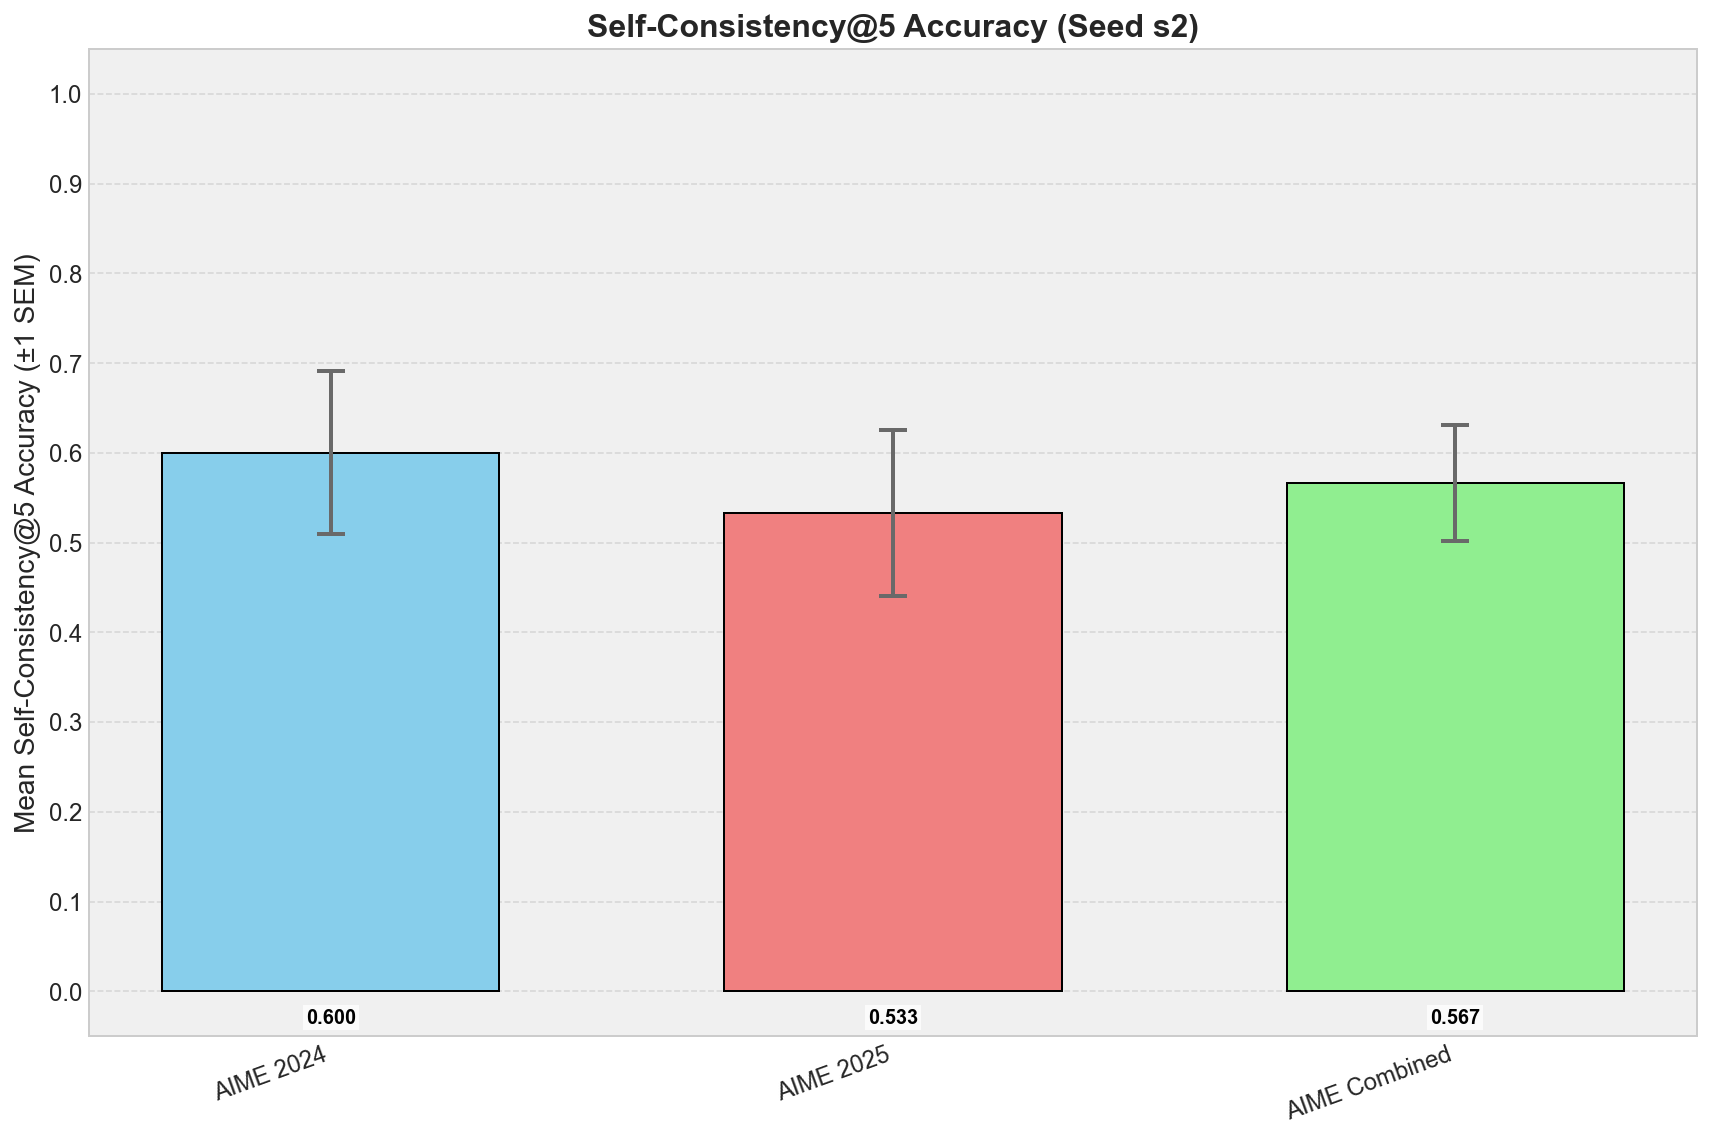


--- Plotted Statistics (Seed s2) ---
  AIME 2024: Mean = 0.600, SEM = 0.091
  AIME 2025: Mean = 0.533, SEM = 0.093
  AIME Combined: Mean = 0.567, SEM = 0.065

--- Generating Plot for Seed s3 ---


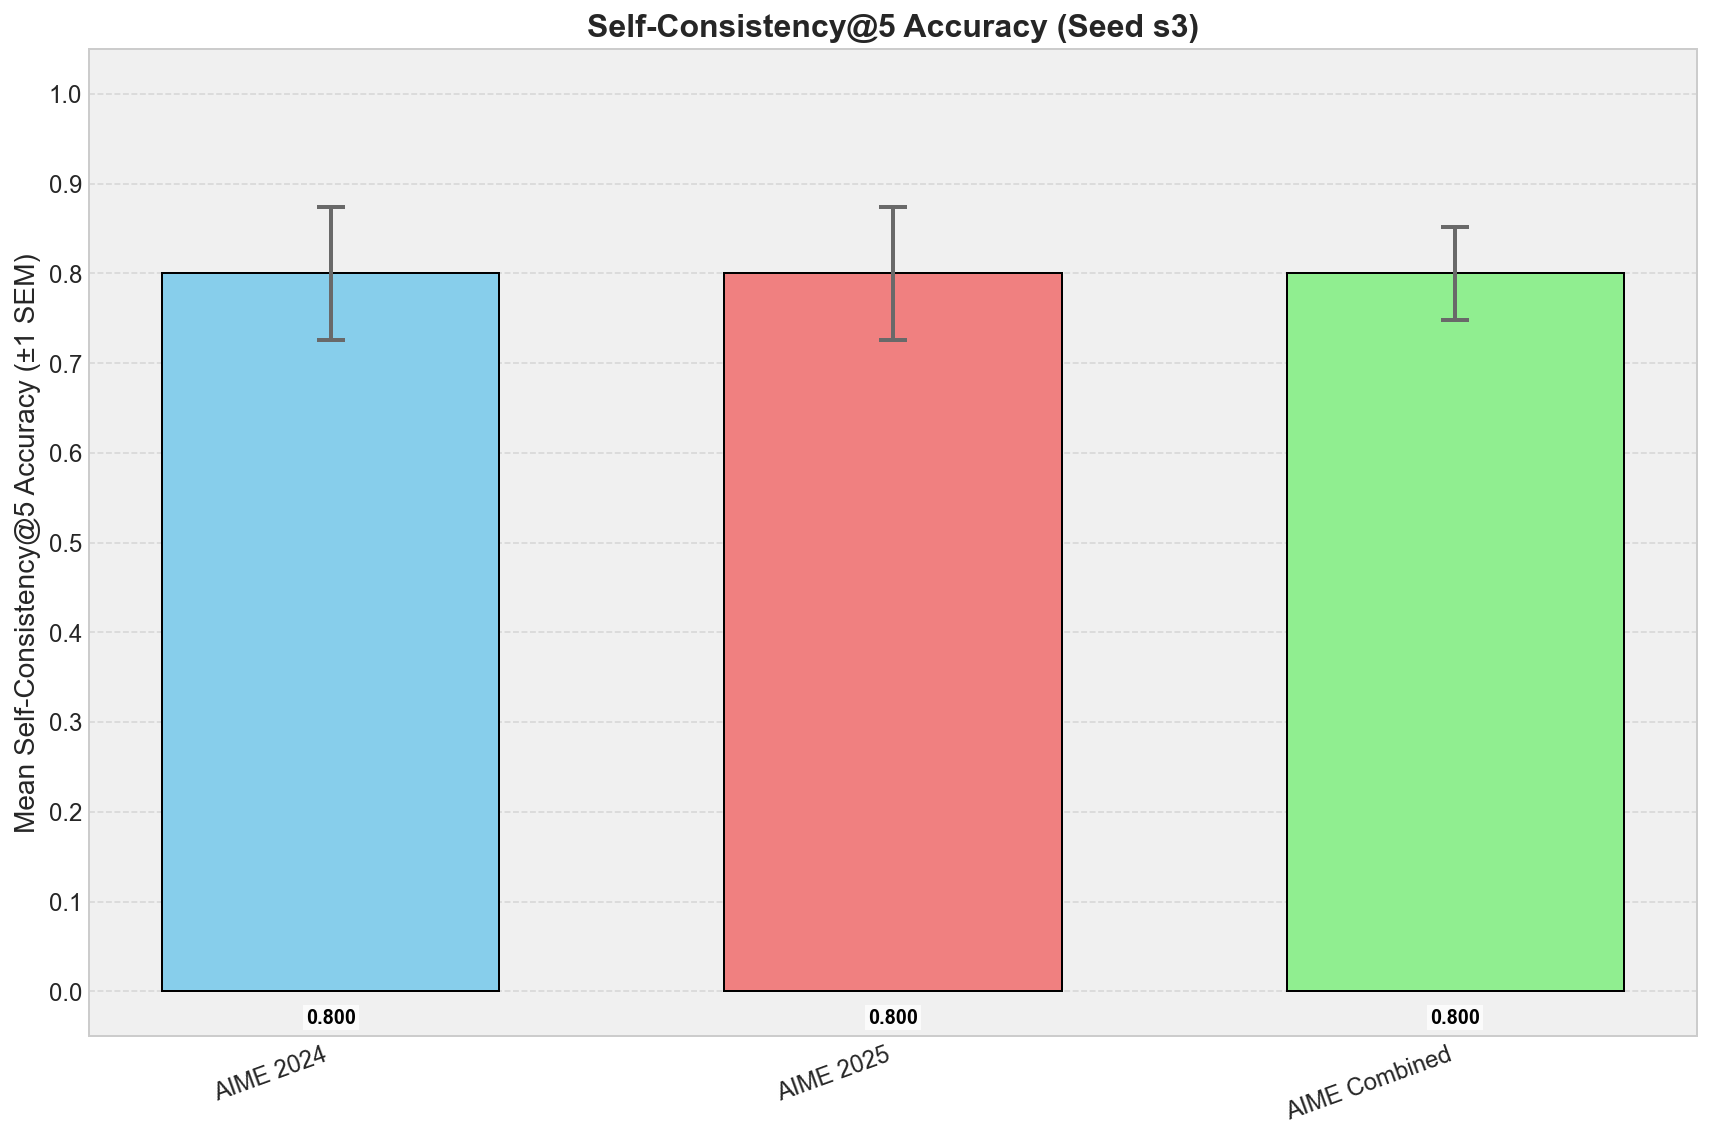


--- Plotted Statistics (Seed s3) ---
  AIME 2024: Mean = 0.800, SEM = 0.074
  AIME 2025: Mean = 0.800, SEM = 0.074
  AIME Combined: Mean = 0.800, SEM = 0.052

Overall analysis DataFrame saved to: pass_consensus/self_consistency_analysis_OVERALL_s0s1s3.csv

--- DataFrames returned from analysis ---

DataFrame: s0 (Head)
  problem_id year_seed  base_year seed majority_voted_answer  \
0   2024-I-4   2024_s0       2024   s0                   116   
1  2024-II-4   2024_s0       2024   s0                    33   
2   2024-I-3   2024_s0       2024   s0                   809   
3  2024-II-6   2024_s0       2024   s0                    55   
4   2024-I-7   2024_s0       2024   s0                   540   

  answer_frequencies ground_truth_answer  tie_in_majority_vote  \
0         {'116': 5}                 116                 False   
1          {'33': 5}                  33                 False   
2         {'809': 5}                 809                 False   
3          {'55': 5}         

In [33]:
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from collections import Counter # Used by evaluate_problem_self_consistency_v3

# --- Helper Function: evaluate_problem_self_consistency_v3 (MUST BE DEFINED) ---
# (Copied from user's provided context in previous turn to make this script runnable)
def evaluate_problem_self_consistency_v3(problem_data):
    solutions = problem_data.get("solutions", [])
    correct_answer_ground_truth = problem_data.get("correct_answer")
    default_answer_counts = Counter()
    if not solutions or correct_answer_ground_truth is None:
        return False, None, default_answer_counts, False
    answer_submissions = []
    for i, sol in enumerate(solutions):
        answer = sol.get("answer")
        if answer is not None and isinstance(answer, str) and answer.strip():
            answer_submissions.append({"answer_text": answer, "index": i})
    if not answer_submissions:
        return False, None, default_answer_counts, False
    answer_counts = Counter(sub["answer_text"] for sub in answer_submissions)
    max_freq = 0
    if answer_counts: max_freq = max(answer_counts.values())
    else: return False, None, default_answer_counts, False
    candidate_answers = [ans_text for ans_text, freq in answer_counts.items() if freq == max_freq]
    was_tie_in_majority_vote = len(candidate_answers) > 1
    majority_voted_answer = None
    if not candidate_answers: return False, None, answer_counts, False
    if len(candidate_answers) == 1: majority_voted_answer = candidate_answers[0]
    else:
        min_index_for_tied_answers = float('inf')
        for tied_ans_option in candidate_answers:
            for sub in answer_submissions:
                if sub["answer_text"] == tied_ans_option:
                    if sub["index"] < min_index_for_tied_answers:
                        min_index_for_tied_answers = sub["index"]
                        majority_voted_answer = tied_ans_option
                    break
    if majority_voted_answer is None: return False, None, answer_counts, was_tie_in_majority_vote
    is_consistent = (str(majority_voted_answer).strip() == str(correct_answer_ground_truth).strip())
    return is_consistent, majority_voted_answer, answer_counts, was_tie_in_majority_vote
# --- End of evaluate_problem_self_consistency_v3 ---

# --- Helper Function: split_into_2024_2025 ---
def split_into_2024_2025(problem_list):
    results_2024 = []
    results_2025 = []
    if not isinstance(problem_list, list):
        # print(f"Warning: input to split_into_2024_2025 is not a list: {type(problem_list)}")
        return results_2024, results_2025
    for res_item in problem_list:
        if not isinstance(res_item, dict):
            # print(f"Warning: item in problem_list is not a dict: {res_item}")
            continue
        problem_id = res_item.get('problem_id')
        if problem_id is None:
            results_2025.append(res_item) # Fallback
            continue
        if isinstance(problem_id, str) and problem_id.startswith('2024'):
            results_2024.append(res_item)
        else:
            results_2025.append(res_item)
    return results_2024, results_2025

# --- Helper Function: get_mean_and_sem ---
def get_mean_and_sem(series):
    if series.empty: return 0, 0
    mean_val = series.mean()
    sem_val = sem(series) if len(series) >= 2 else 0
    return mean_val, sem_val

# --- Plotting function for per-seed or overall ---
def plot_accuracy_bars(labels, means, sems, title, bar_colors=None, scatter_data=None):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8)) 
    
    if bar_colors is None:
        bar_colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'lightseagreen'] 
    
    if len(labels) > len(bar_colors): 
        cmap = plt.cm.get_cmap('viridis', len(labels))
        bar_colors = [cmap(i) for i in range(len(labels))]

    bars = ax.bar(labels, means, yerr=sems, capsize=7, color=bar_colors[:len(labels)], width=0.6,
                  edgecolor='black', ecolor='dimgray', error_kw={'elinewidth':2, 'capthick':2})

    if scatter_data:
        for i, label in enumerate(labels):
            if label in scatter_data and scatter_data[label]:
                jitter = np.random.normal(0, 0.03, size=len(scatter_data[label])).clip(-0.1, 0.1)
                ax.scatter([i + j for j in jitter], scatter_data[label], 
                           color=bar_colors[i % len(bar_colors)], alpha=0.5, zorder=5, s=50, edgecolor='k', linewidth=0.5)

    ax.set_ylabel('Mean Self-Consistency@5 Accuracy (±1 SEM)', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylim(-0.05, 1.05) 
    plt.yticks(np.arange(0, 1.1, 0.1))

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        
        # Position text at the bottom of the bar
        text_y_pos = -0.04  # Small offset from the y-axis baseline

        plt.text(bar.get_x() + bar.get_width()/2.0, text_y_pos, f'{yval:.3f}',
                 ha='center', va='bottom', # va='bottom' aligns bottom of text to text_y_pos
                 fontsize=10, color='black', fontweight='bold', # slightly smaller font for bottom
                 bbox=dict(facecolor='white', alpha=0.75, pad=1.5, edgecolor='none')) # Ensure bbox is visible

    plt.xticks(fontsize=12, rotation=20, ha="right") 
    plt.yticks(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.grid(axis='x', linestyle='')
    ax.set_facecolor('#f0f0f0')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.show()

# --- Main Analysis (Copy from your consensus.ipynb, lines 115-221) ---
def run_consensus_analysis_on_seeds(base_dir="pass_consensus"):
    all_problem_analysis_data = []
    seed_files_info = [
        {"filename": "seed0_pass_consensus.json", "seed_num_str": "s0"},
        {"filename": "seed1_pass_consensus.json", "seed_num_str": "s1"},
        {"filename": "seed2_pass_consensus.json", "seed_num_str": "s2"},
        {"filename": "seed3_pass_consensus.json", "seed_num_str": "s3"}
    ]
    
    dataframes_per_seed = {} 

    print(f"Looking for files in directory: {os.path.abspath(base_dir)}")
    for file_info in seed_files_info:
        filepath = os.path.join(base_dir, file_info["filename"])
        seed_num_str = file_info["seed_num_str"]
        current_seed_data = [] 
        print(f"\nProcessing file: {filepath} (Seed {seed_num_str})")
        if not os.path.exists(filepath):
            print(f"  Error: File not found: {filepath}. Skipping.")
            continue
        try:
            with open(filepath, 'r', encoding='utf-8') as f: data = json.load(f)
        except Exception as e:
            print(f"  Error loading/parsing {filepath}: {e}. Skipping.")
            continue
        if "results" not in data or not isinstance(data["results"], list):
            print(f"  Warning: 'results' key missing/invalid in {filepath}. Skipping.")
            continue
            
        problems_all_for_file = data["results"]
        results_2024_seed, results_2025_seed = split_into_2024_2025(problems_all_for_file)

        datasets_to_process_for_seed = [
            {'year_seed_label': f'2024_{seed_num_str}', 'base_year': 2024, 'problem_list': results_2024_seed},
            {'year_seed_label': f'2025_{seed_num_str}', 'base_year': 2025, 'problem_list': results_2025_seed}
        ]
        for dataset in datasets_to_process_for_seed:
            for problem_entry in dataset['problem_list']:
                if not isinstance(problem_entry, dict): continue
                is_consistent, maj_vote_ans, answer_freq_counter, was_tie = \
                    evaluate_problem_self_consistency_v3(problem_entry)
                
                problem_result_data = {
                    "problem_id": problem_entry.get("problem_id"),
                    "year_seed": dataset['year_seed_label'],
                    "base_year": dataset['base_year'],
                    "seed": seed_num_str,
                    "majority_voted_answer": maj_vote_ans,
                    "answer_frequencies": dict(answer_freq_counter),
                    "ground_truth_answer": problem_entry.get("correct_answer"),
                    "tie_in_majority_vote": was_tie,
                    "self_consistent": 1 if is_consistent else 0
                }
                all_problem_analysis_data.append(problem_result_data)
                current_seed_data.append(problem_result_data)
        
        if current_seed_data:
            df_current_seed = pd.DataFrame(current_seed_data)
            dataframes_per_seed[seed_num_str] = df_current_seed
            seed_csv_path = os.path.join(base_dir, f"self_consistency_analysis_{seed_num_str}.csv")
            df_current_seed.to_csv(seed_csv_path, index=False)
            print(f"  DataFrame for seed {seed_num_str} saved to: {seed_csv_path}")
    
    if not all_problem_analysis_data:
        print("\nNo data processed. Exiting.")
        return {} 

    overall_self_consistency_df = pd.DataFrame(all_problem_analysis_data)
    overall_self_consistency_df['self_consistent'] = pd.to_numeric(overall_self_consistency_df['self_consistent'], errors='coerce')
    overall_self_consistency_df.dropna(subset=['self_consistent'], inplace=True)
    if overall_self_consistency_df.empty:
        print("\nOverall DataFrame is empty after cleaning. Cannot generate plots.")
        return dataframes_per_seed 

    print(f"\nTotal problems processed into Overall DataFrame: {len(overall_self_consistency_df)}")
    
    scatter_points_for_averaged_plot = {
        'AIME 2024 (avg. seeds)': [],
        'AIME 2025 (avg. seeds)': [],
        'AIME Combined (avg. seeds)': []
    }
    for seed_str, df_seed in dataframes_per_seed.items():
        if df_seed.empty: continue
        df_seed_cleaned = df_seed.copy()
        df_seed_cleaned['self_consistent'] = pd.to_numeric(df_seed_cleaned['self_consistent'], errors='coerce').dropna()
        if df_seed_cleaned.empty: continue

        acc_2024 = df_seed_cleaned[df_seed_cleaned['base_year'] == 2024]['self_consistent'].mean()
        acc_2025 = df_seed_cleaned[df_seed_cleaned['base_year'] == 2025]['self_consistent'].mean()
        acc_combined = df_seed_cleaned['self_consistent'].mean() 
        
        if not pd.isna(acc_2024): scatter_points_for_averaged_plot['AIME 2024 (avg. seeds)'].append(acc_2024)
        if not pd.isna(acc_2025): scatter_points_for_averaged_plot['AIME 2025 (avg. seeds)'].append(acc_2025)
        if not pd.isna(acc_combined): scatter_points_for_averaged_plot['AIME Combined (avg. seeds)'].append(acc_combined)

    plot_stats_overall = {}
    df_2024_overall = overall_self_consistency_df[overall_self_consistency_df['base_year'] == 2024]
    mean_2024_ov, sem_2024_ov = get_mean_and_sem(df_2024_overall['self_consistent'])
    plot_stats_overall['AIME 2024 (avg. seeds)'] = {'mean': mean_2024_ov, 'sem': sem_2024_ov}

    df_2025_overall = overall_self_consistency_df[overall_self_consistency_df['base_year'] == 2025]
    mean_2025_ov, sem_2025_ov = get_mean_and_sem(df_2025_overall['self_consistent'])
    plot_stats_overall['AIME 2025 (avg. seeds)'] = {'mean': mean_2025_ov, 'sem': sem_2025_ov}
    
    df_combined_overall = overall_self_consistency_df
    mean_comb_ov, sem_comb_ov = get_mean_and_sem(df_combined_overall['self_consistent'])
    plot_stats_overall['AIME Combined (avg. seeds)'] = {'mean': mean_comb_ov, 'sem': sem_comb_ov}

    plot_accuracy_bars(list(plot_stats_overall.keys()),
                       [s['mean'] for s in plot_stats_overall.values()],
                       [s['sem'] for s in plot_stats_overall.values()],
                       'Self-Consistency@5 Accuracy (Averaged Across Seeds)',
                       scatter_data=scatter_points_for_averaged_plot) 
    print("\n--- Plotted Statistics (Averaged Across Seeds) ---")
    for label, stats in plot_stats_overall.items(): print(f"  {label}: Mean = {stats['mean']:.3f}, SEM = {stats['sem']:.3f}")

    for seed_val in sorted(dataframes_per_seed.keys()): 
        print(f"\n--- Generating Plot for Seed {seed_val} ---")
        df_seed_specific = dataframes_per_seed[seed_val]
        if df_seed_specific.empty:
            print(f"  No data for seed {seed_val}. Skipping plot.")
            continue
        
        df_seed_specific_cleaned = df_seed_specific.copy()
        df_seed_specific_cleaned['self_consistent'] = pd.to_numeric(df_seed_specific_cleaned['self_consistent'], errors='coerce').dropna()
        if df_seed_specific_cleaned.empty:
            print(f"  No valid data for seed {seed_val} after cleaning. Skipping plot.")
            continue

        plot_stats_seed = {}
        df_2024_seed = df_seed_specific_cleaned[df_seed_specific_cleaned['base_year'] == 2024]
        mean_2024_s, sem_2024_s = get_mean_and_sem(df_2024_seed['self_consistent'])
        plot_stats_seed['AIME 2024'] = {'mean': mean_2024_s, 'sem': sem_2024_s}

        df_2025_seed = df_seed_specific_cleaned[df_seed_specific_cleaned['base_year'] == 2025]
        mean_2025_s, sem_2025_s = get_mean_and_sem(df_2025_seed['self_consistent'])
        plot_stats_seed['AIME 2025'] = {'mean': mean_2025_s, 'sem': sem_2025_s}
        
        df_combined_seed = df_seed_specific_cleaned
        mean_comb_s, sem_comb_s = get_mean_and_sem(df_combined_seed['self_consistent'])
        plot_stats_seed['AIME Combined'] = {'mean': mean_comb_s, 'sem': sem_comb_s}

        plot_accuracy_bars(list(plot_stats_seed.keys()),
                           [s['mean'] for s in plot_stats_seed.values()],
                           [s['sem'] for s in plot_stats_seed.values()],
                           f'Self-Consistency@5 Accuracy (Seed {seed_val})')
        print(f"\n--- Plotted Statistics (Seed {seed_val}) ---")
        for label, stats in plot_stats_seed.items(): print(f"  {label}: Mean = {stats['mean']:.3f}, SEM = {stats['sem']:.3f}")

    overall_csv_path = os.path.join(base_dir, "self_consistency_analysis_OVERALL_s0s1s3.csv")
    overall_self_consistency_df.to_csv(overall_csv_path, index=False)
    print(f"\nOverall analysis DataFrame saved to: {overall_csv_path}")
    
    dataframes_per_seed['overall'] = overall_self_consistency_df 
    return dataframes_per_seed

# --- Main execution (ensure this is at the very end or in a separate cell if in Jupyter) ---
if __name__ == '__main__':
    TARGET_DIR = "pass_consensus"
    returned_dataframes = run_consensus_analysis_on_seeds(base_dir=TARGET_DIR)
    
    print("\n--- DataFrames returned from analysis ---")
    if returned_dataframes: # Check if dict is not empty
        for name, df_item in returned_dataframes.items():
            print(f"\nDataFrame: {name} (Head)")
            if not df_item.empty:
                print(df_item.head())
            else:
                print(" (empty) ")
    else:
        print("No DataFrames were returned from the analysis.")


In [34]:
df = pd.read_csv("pass_consensus/self_consistency_analysis_s3.csv")
df

,problem_id,year_seed,base_year,seed,majority_voted_answer,answer_frequencies,ground_truth_answer,tie_in_majority_vote,self_consistent
0,2024-II-4,2024_s3,2024,s3,33,{'33': 5},33,False,1
1,2024-II-12,2024_s3,2024,s3,23,{'23': 5},23,False,1
2,2024-I-4,2024_s3,2024,s3,116,{'116': 5},116,False,1
3,2024-I-3,2024_s3,2024,s3,809,{'809': 5},809,False,1
4,2024-I-8,2024_s3,2024,s3,254,"{'254': 1, '197': 1, '2929': 1, '144': 1, '103...",197,True,0
5,2024-I-12,2024_s3,2024,s3,72,"{'72': 2, '100': 1, '12': 1, '24': 1}",385,False,0
6,2024-I-11,2024_s3,2024,s3,259,"{'259': 1, '419': 1, '53': 1, '33': 1, '273': 1}",371,True,0
7,2024-II-11,2024_s3,2024,s3,601,"{'401': 1, '15': 1, '601': 2, '7': 1}",601,False,1
8,2024-I-2,2024_s3,2024,s3,25,{'25': 5},25,False,1
9,2024-II-6,2024_s3,2024,s3,55,{'55': 5},55,False,1


## For Ties Add the Proportion of Correct / k

Looking for files in directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus

Processing file: pass_consensus/seed0_pass_consensus.json (Seed s0)
  DataFrame for seed s0 saved to: pass_consensus/self_consistency_analysis_s0_conditional_fractional.csv

Processing file: pass_consensus/seed1_pass_consensus.json (Seed s1)
  DataFrame for seed s1 saved to: pass_consensus/self_consistency_analysis_s1_conditional_fractional.csv

Processing file: pass_consensus/seed2_pass_consensus.json (Seed s2)
  DataFrame for seed s2 saved to: pass_consensus/self_consistency_analysis_s2_conditional_fractional.csv

Processing file: pass_consensus/seed3_pass_consensus.json (Seed s3)
  DataFrame for seed s3 saved to: pass_consensus/self_consistency_analysis_s3_conditional_fractional.csv

Total problems processed into Overall DataFrame: 240


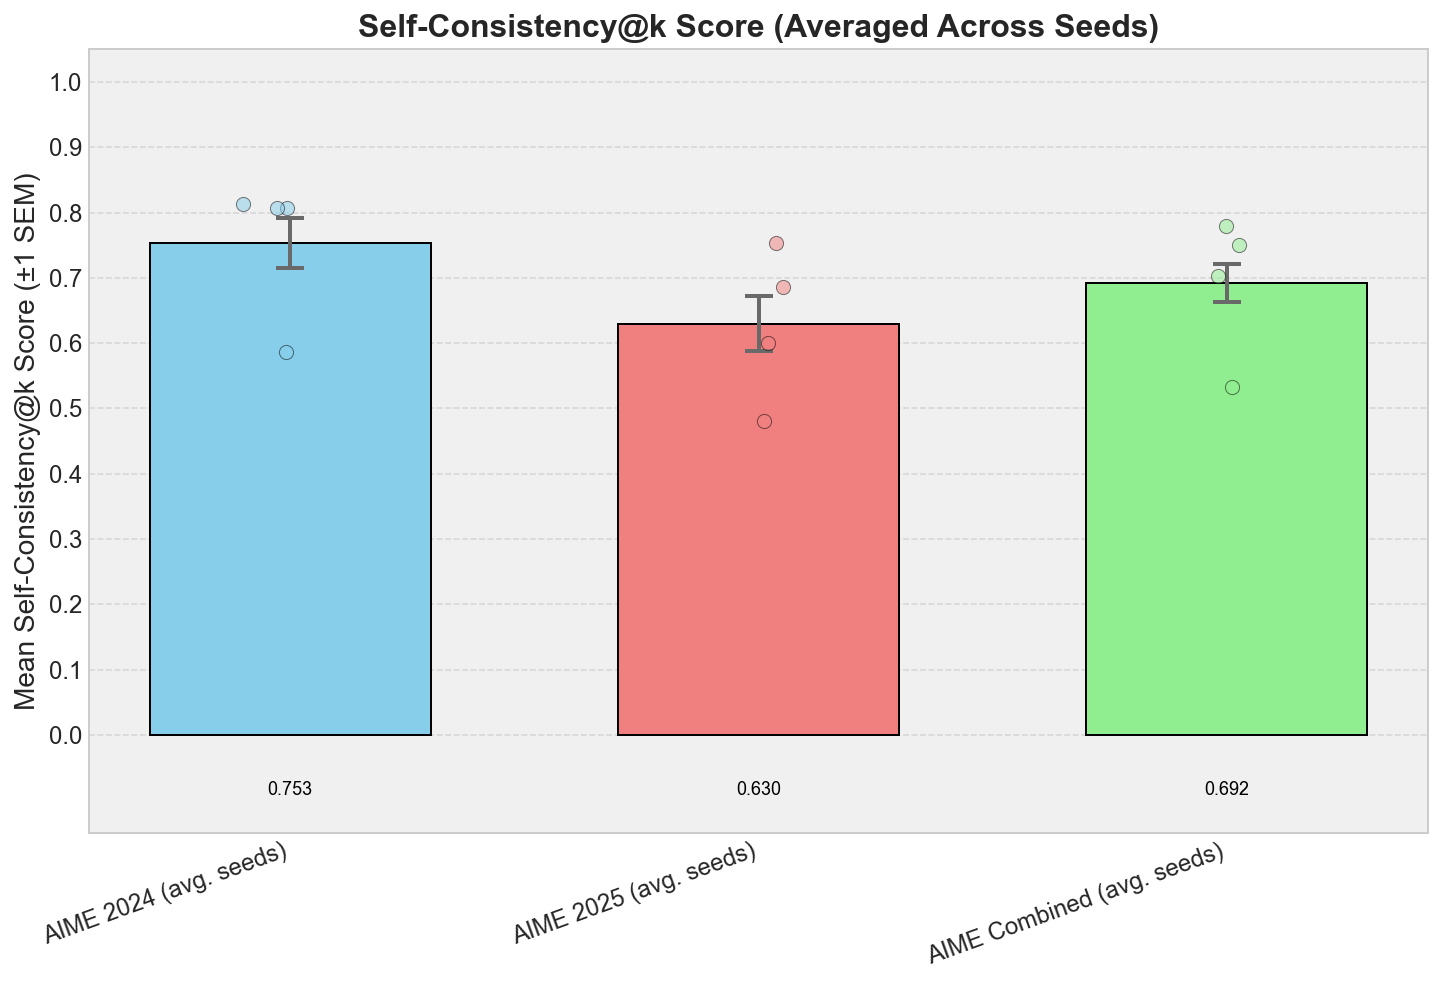


--- Plotted Statistics (Averaged Across Seeds) ---
  AIME 2024 (avg. seeds): Mean = 0.753, SEM = 0.039
  AIME 2025 (avg. seeds): Mean = 0.630, SEM = 0.042
  AIME Combined (avg. seeds): Mean = 0.692, SEM = 0.029

--- Generating Plot for Seed s0 ---


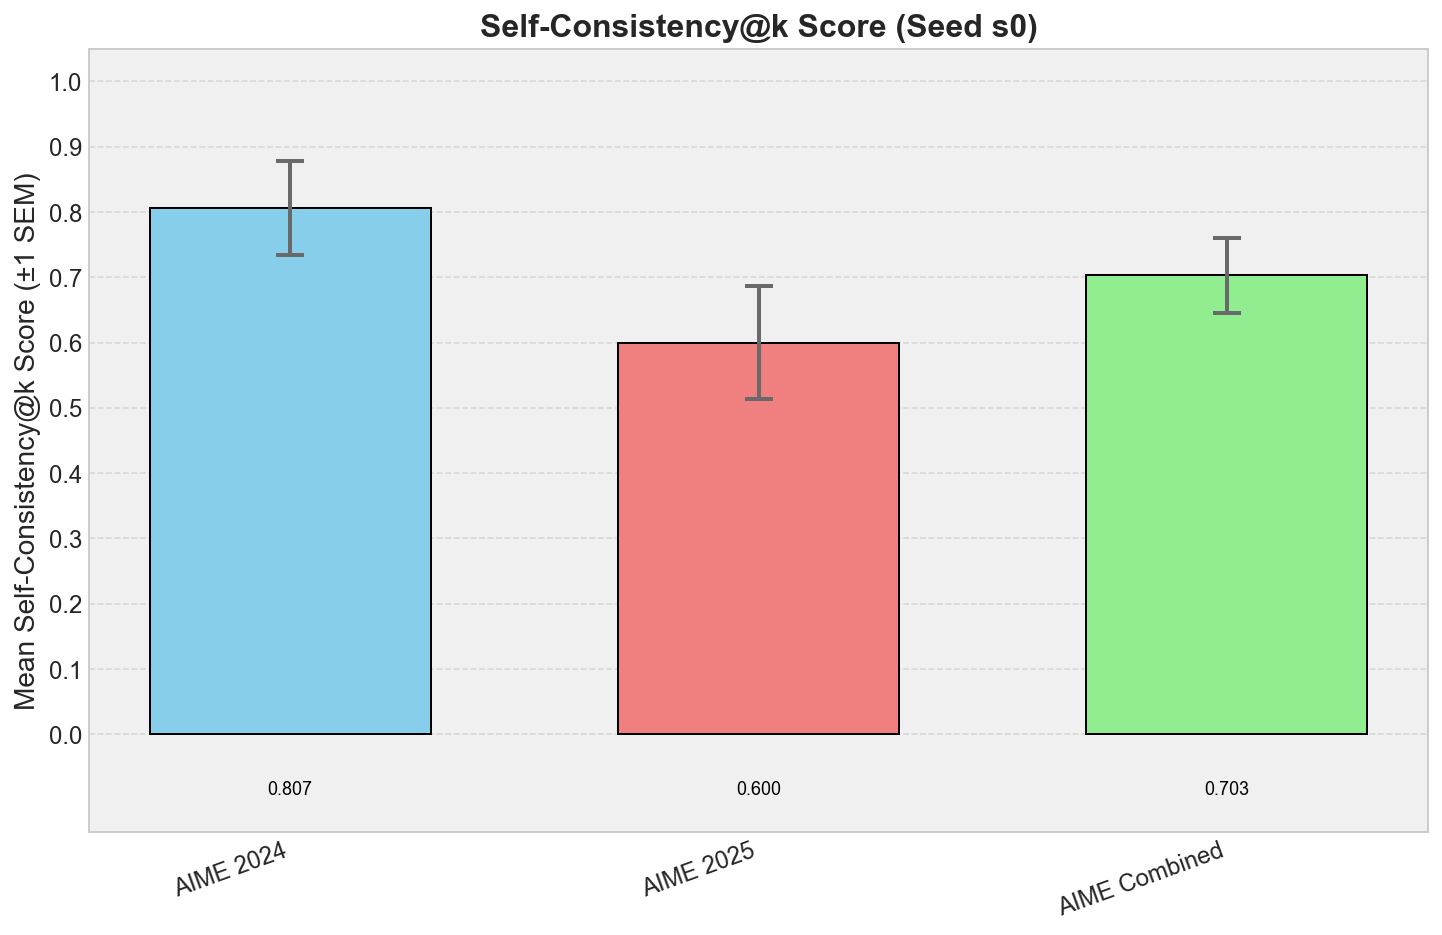


--- Plotted Statistics (Seed s0) ---
  AIME 2024: Mean = 0.807, SEM = 0.072
  AIME 2025: Mean = 0.600, SEM = 0.086
  AIME Combined: Mean = 0.703, SEM = 0.057

--- Generating Plot for Seed s1 ---


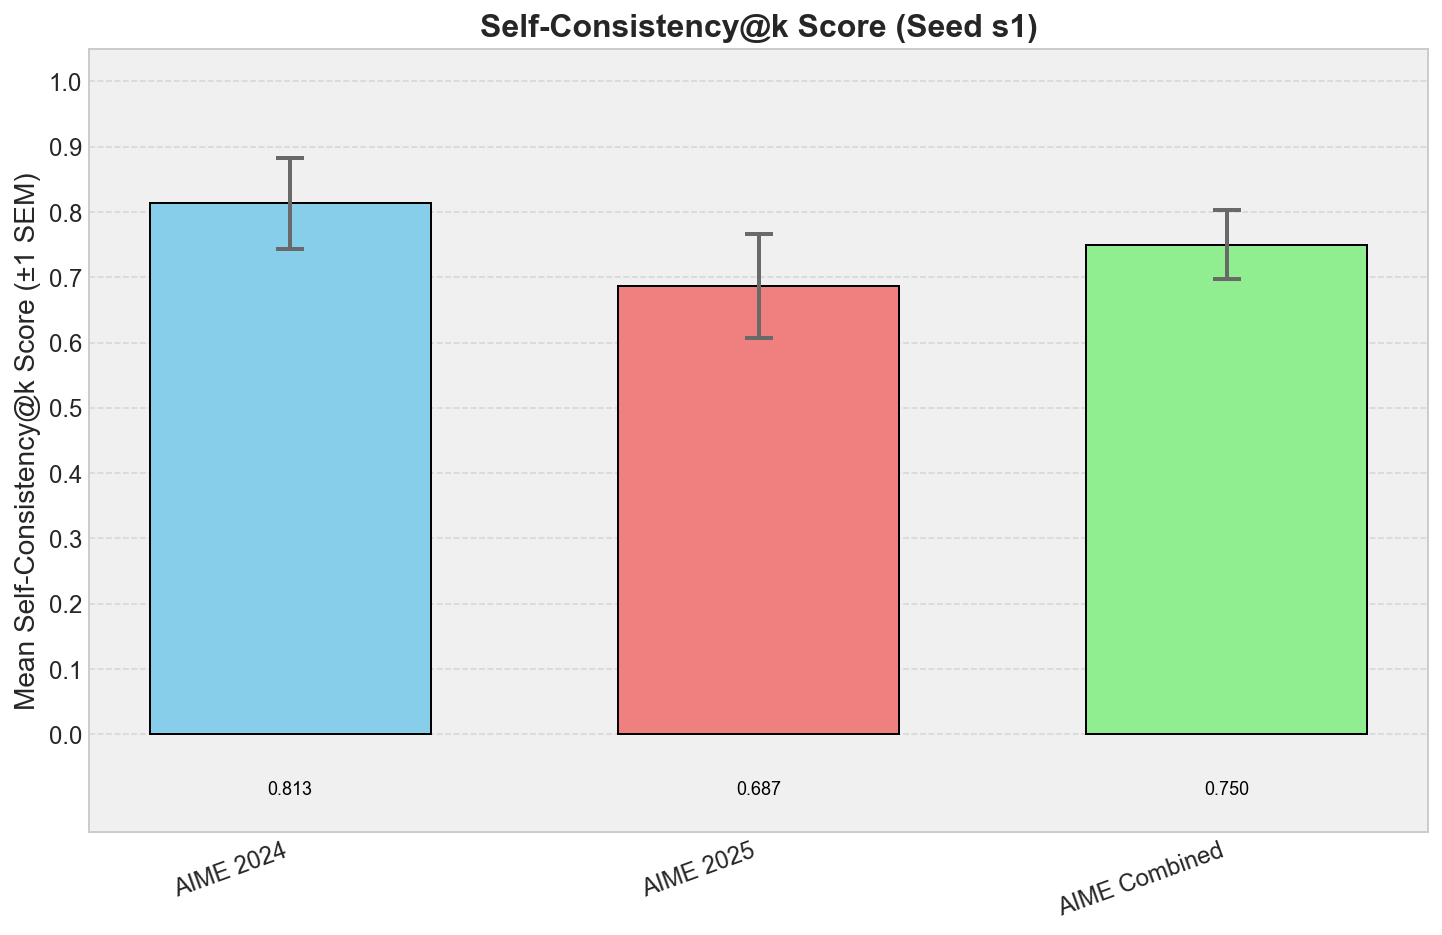


--- Plotted Statistics (Seed s1) ---
  AIME 2024: Mean = 0.813, SEM = 0.070
  AIME 2025: Mean = 0.687, SEM = 0.079
  AIME Combined: Mean = 0.750, SEM = 0.053

--- Generating Plot for Seed s2 ---


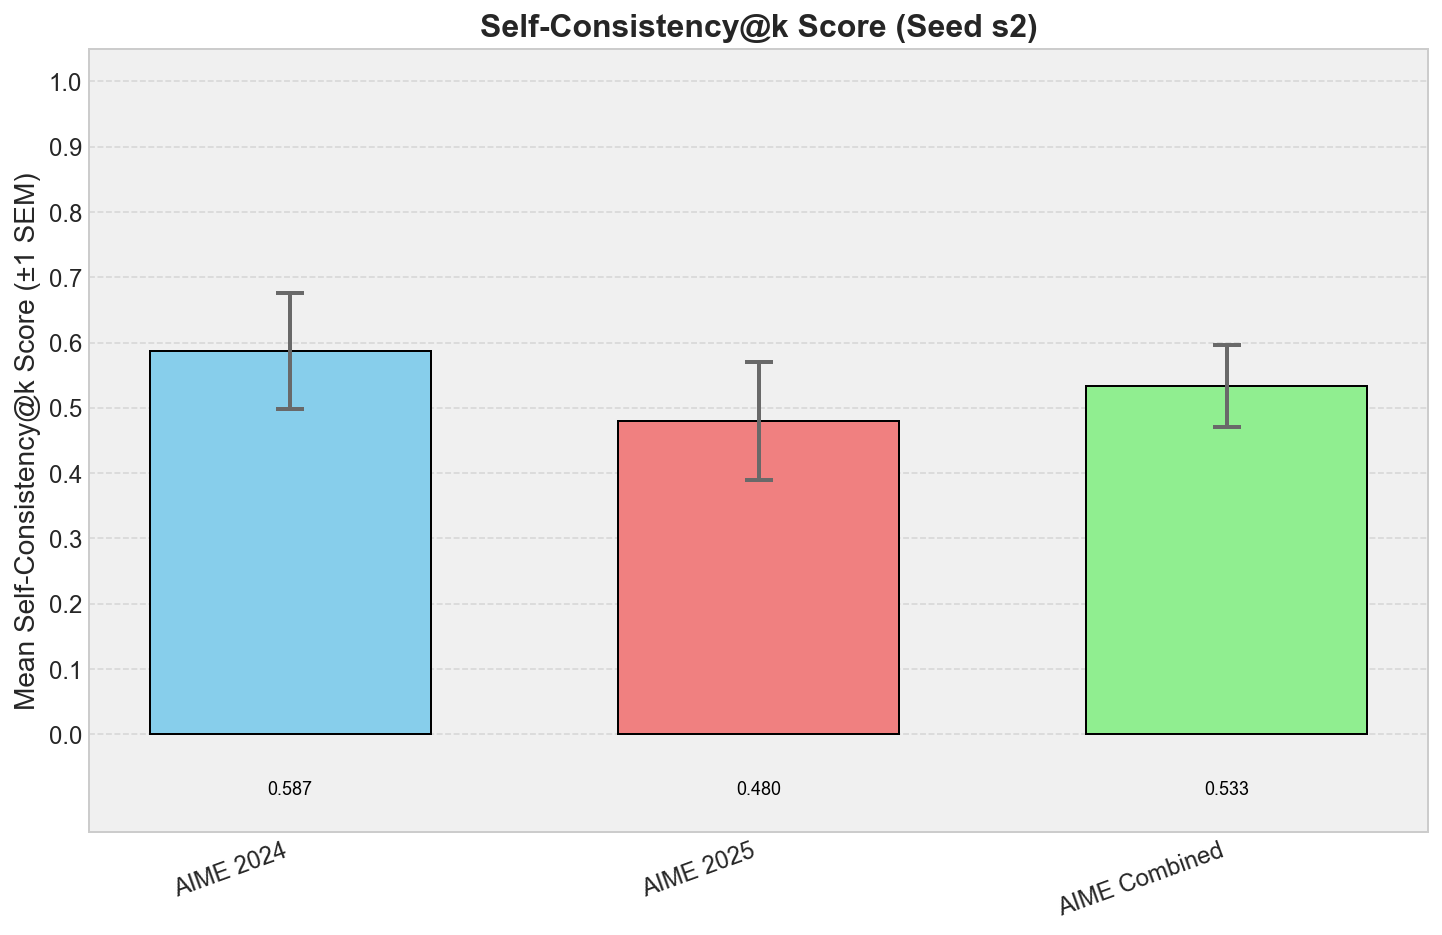


--- Plotted Statistics (Seed s2) ---
  AIME 2024: Mean = 0.587, SEM = 0.089
  AIME 2025: Mean = 0.480, SEM = 0.091
  AIME Combined: Mean = 0.533, SEM = 0.063

--- Generating Plot for Seed s3 ---


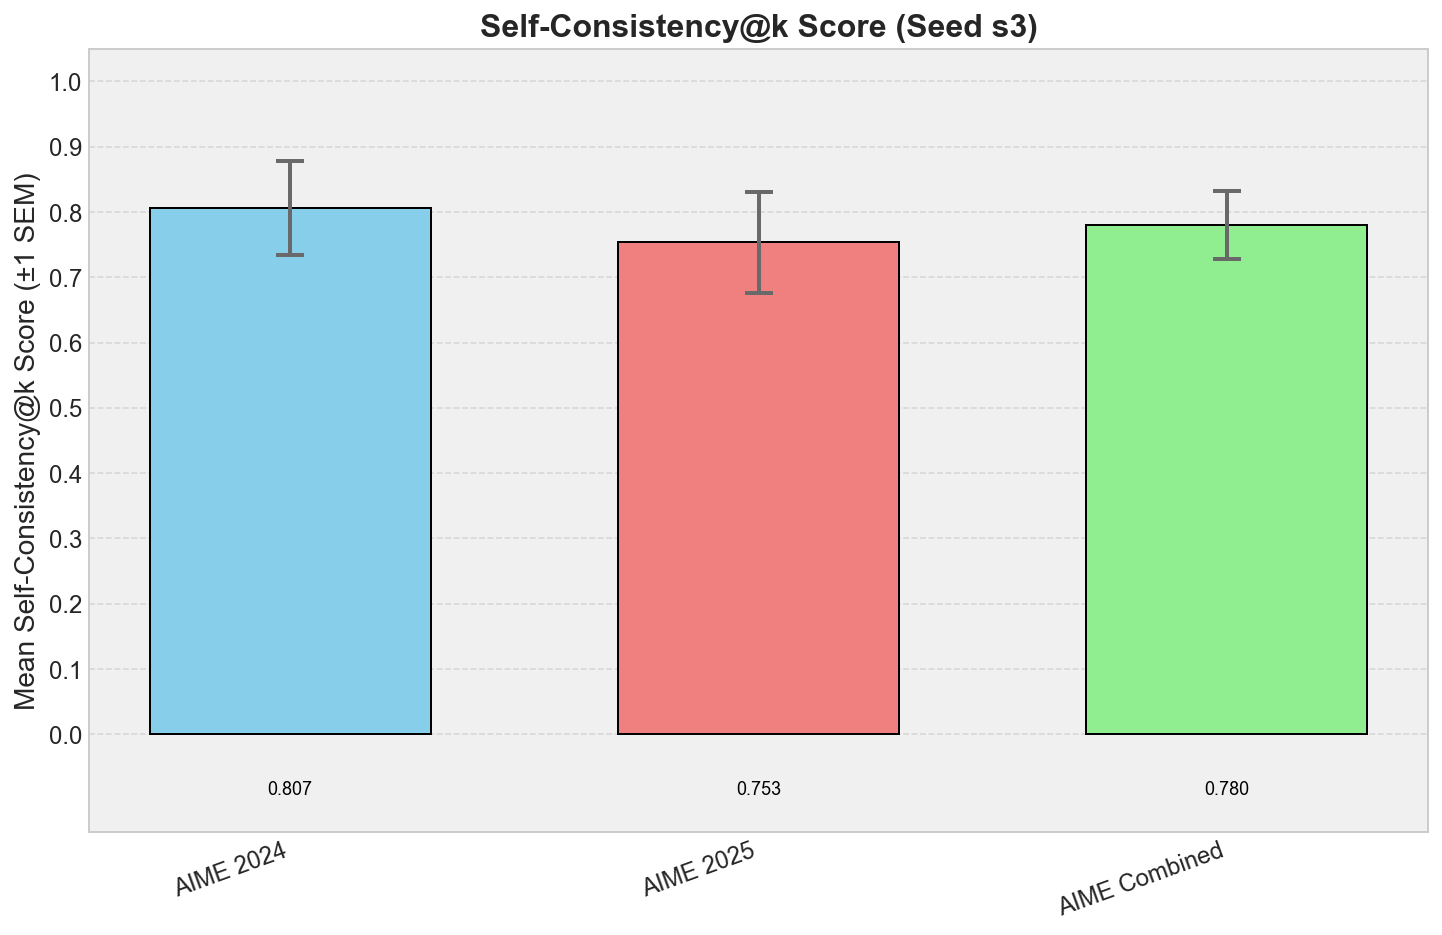


--- Plotted Statistics (Seed s3) ---
  AIME 2024: Mean = 0.807, SEM = 0.072
  AIME 2025: Mean = 0.753, SEM = 0.077
  AIME Combined: Mean = 0.780, SEM = 0.052

Overall analysis DataFrame saved to: pass_consensus/self_consistency_analysis_OVERALL_s0s1s3_conditional_fractional.csv

--- DataFrames returned from analysis ---

DataFrame: s0 (Head)
  problem_id year_seed  base_year seed majority_voted_answer_by_index  \
0   2024-I-4   2024_s0       2024   s0                            116   
1  2024-II-4   2024_s0       2024   s0                             33   
2   2024-I-3   2024_s0       2024   s0                            809   
3  2024-II-6   2024_s0       2024   s0                             55   
4   2024-I-7   2024_s0       2024   s0                            540   

  answer_frequencies ground_truth_answer  tie_in_frequency  \
0         {'116': 5}                 116             False   
1          {'33': 5}                  33             False   
2         {'809': 5}          

In [35]:
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from collections import Counter # Used by evaluate_problem_self_consistency_v3

# --- Helper Function: evaluate_problem_self_consistency_v3 (REVISED LOGIC) ---
def evaluate_problem_self_consistency_v3(problem_data):
    """
    Evaluates self-consistency.
    - If there's a clear single majority answer: score is 1 if it's correct, 0 otherwise.
    - If there's a tie in frequency for the most popular answer(s):
        - AND the correct answer is among these tied top answers:
            score is (count of correct answer in all solutions) / (total solutions).
        - Else (correct answer not among top tied, or tie doesn't involve correct):
            score is 1 if the majority_voted_answer_by_index (after index tie-break) is correct, 0 otherwise.
            (This effectively means if the correct answer wasn't in the top tied group, it's 0.
             If it was, but this path is taken, it means the fractional score was already applied).
             Revisiting: The "else" case should simply fall back to the standard majority vote on the
             `majority_voted_answer_by_index`.

    Args:
        problem_data (dict): A dictionary representing a single problem.

    Returns:
        tuple: (
            consistency_score (float),
            majority_voted_answer_by_index (str or None),
            answer_counts (collections.Counter),
            was_tie_in_frequency (bool)
        )
    """
    solutions = problem_data.get("solutions", [])
    correct_answer_ground_truth = problem_data.get("correct_answer")
    default_answer_counts = Counter()

    if not solutions or correct_answer_ground_truth is None:
        return 0.0, None, default_answer_counts, False

    answer_submissions = []
    for i, sol in enumerate(solutions):
        answer = sol.get("answer")
        if answer is not None and isinstance(answer, str) and answer.strip():
            answer_submissions.append({"answer_text": answer, "index": i})

    if not answer_submissions:
        return 0.0, None, default_answer_counts, False

    answer_counts = Counter(sub["answer_text"] for sub in answer_submissions)
    correct_answer_str = str(correct_answer_ground_truth).strip()
    
    max_freq = 0
    if answer_counts: max_freq = max(answer_counts.values())
    else: return 0.0, None, default_answer_counts, False

    candidate_answers_set = {ans_text for ans_text, freq in answer_counts.items() if freq == max_freq}
    was_tie_in_frequency = len(candidate_answers_set) > 1
    
    # Determine the single "majority" answer using index tie-breaking if needed (for fallback)
    majority_voted_answer_by_index = None
    if not candidate_answers_set: return 0.0, None, answer_counts, False 
    if len(candidate_answers_set) == 1:
        majority_voted_answer_by_index = list(candidate_answers_set)[0]
    else: 
        min_index_for_tied_answers = float('inf')
        for tied_ans_option in candidate_answers_set:
            for sub in answer_submissions:
                if sub["answer_text"] == tied_ans_option:
                    if sub["index"] < min_index_for_tied_answers:
                        min_index_for_tied_answers = sub["index"]
                        majority_voted_answer_by_index = tied_ans_option
                    break 
    
    consistency_score = 0.0
    if was_tie_in_frequency and correct_answer_str in candidate_answers_set:
        # Apply fractional score ONLY if there's a frequency tie AND correct answer is in that tied group
        num_times_correct_answer_appeared = answer_counts.get(correct_answer_str, 0)
        total_number_of_solution_slots = len(solutions)
        if total_number_of_solution_slots > 0:
            consistency_score = num_times_correct_answer_appeared / total_number_of_solution_slots
    else:
        # Standard majority vote logic (based on the single answer derived from frequency and index tie-breaking)
        if majority_voted_answer_by_index is not None and \
           str(majority_voted_answer_by_index).strip() == correct_answer_str:
            consistency_score = 1.0
        else:
            consistency_score = 0.0
            
    return consistency_score, majority_voted_answer_by_index, answer_counts, was_tie_in_frequency

# --- Helper Function: split_into_2024_2025 ---
def split_into_2024_2025(problem_list):
    results_2024 = []
    results_2025 = []
    if not isinstance(problem_list, list):
        return results_2024, results_2025
    for res_item in problem_list:
        if not isinstance(res_item, dict):
            continue
        problem_id = res_item.get('problem_id')
        if problem_id is None:
            results_2025.append(res_item) 
            continue
        if isinstance(problem_id, str) and problem_id.startswith('2024'):
            results_2024.append(res_item)
        else:
            results_2025.append(res_item)
    return results_2024, results_2025

# --- Helper Function: get_mean_and_sem ---
def get_mean_and_sem(series):
    if series.empty: return 0, 0
    mean_val = series.mean()
    sem_val = sem(series) if len(series) >= 2 else 0
    return mean_val, sem_val

# --- Plotting function for per-seed or overall ---
def plot_accuracy_bars(labels, means, sems, title, bar_colors=None, scatter_data=None):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8)) 
    if bar_colors is None:
        bar_colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'lightseagreen'] 
    if len(labels) > len(bar_colors): 
        cmap = plt.cm.get_cmap('viridis', len(labels))
        bar_colors = [cmap(i) for i in range(len(labels))]
    bars = ax.bar(labels, means, yerr=sems, capsize=7, color=bar_colors[:len(labels)], width=0.6,
                  edgecolor='black', ecolor='dimgray', error_kw={'elinewidth':2, 'capthick':2})
    if scatter_data:
        for i, label in enumerate(labels):
            if label in scatter_data and scatter_data[label]:
                jitter = np.random.normal(0, 0.03, size=len(scatter_data[label])).clip(-0.1, 0.1)
                ax.scatter([i + j for j in jitter], scatter_data[label], 
                           color=bar_colors[i % len(bar_colors)], alpha=0.5, zorder=5, s=50, edgecolor='k', linewidth=0.5)
    ax.set_ylabel('Mean Self-Consistency@k Score (±1 SEM)', fontsize=14) 
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylim(-0.15, 1.05) 
    plt.yticks(np.arange(0, 1.1, 0.1))
    for i, bar in enumerate(bars):
        yval = bar.get_height() 
        text_y_pos = -0.07  
        plt.text(bar.get_x() + bar.get_width()/2.0, text_y_pos, f'{yval:.3f}',
                 ha='center', va='top', fontsize=9, color='black', fontweight='normal',
                 bbox=dict(facecolor='white', alpha=0.0, pad=0, edgecolor='none'))
    plt.xticks(fontsize=12, rotation=20, ha="right") 
    plt.yticks(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.grid(axis='x', linestyle='')
    ax.set_facecolor('#f0f0f0')
    fig.patch.set_facecolor('white')
    plt.subplots_adjust(bottom=0.2) 
    plt.show()

# --- Main Analysis (Lines 115-290 from consensus.ipynb, with `self_consistent` using the new score) ---
def run_consensus_analysis_on_seeds(base_dir="pass_consensus"):
    all_problem_analysis_data = []
    seed_files_info = [
        {"filename": "seed0_pass_consensus.json", "seed_num_str": "s0"},
        {"filename": "seed1_pass_consensus.json", "seed_num_str": "s1"},
        {"filename": "seed2_pass_consensus.json", "seed_num_str": "s2"},
        {"filename": "seed3_pass_consensus.json", "seed_num_str": "s3"}
    ]
    dataframes_per_seed = {} 
    print(f"Looking for files in directory: {os.path.abspath(base_dir)}")
    for file_info in seed_files_info:
        filepath = os.path.join(base_dir, file_info["filename"])
        seed_num_str = file_info["seed_num_str"]
        current_seed_data = [] 
        print(f"\nProcessing file: {filepath} (Seed {seed_num_str})")
        if not os.path.exists(filepath):
            print(f"  Error: File not found: {filepath}. Skipping.")
            continue
        try:
            with open(filepath, 'r', encoding='utf-8') as f: data = json.load(f)
        except Exception as e:
            print(f"  Error loading/parsing {filepath}: {e}. Skipping.")
            continue
        if "results" not in data or not isinstance(data["results"], list):
            print(f"  Warning: 'results' key missing/invalid in {filepath}. Skipping.")
            continue
        problems_all_for_file = data["results"]
        results_2024_seed, results_2025_seed = split_into_2024_2025(problems_all_for_file)
        datasets_to_process_for_seed = [
            {'year_seed_label': f'2024_{seed_num_str}', 'base_year': 2024, 'problem_list': results_2024_seed},
            {'year_seed_label': f'2025_{seed_num_str}', 'base_year': 2025, 'problem_list': results_2025_seed}
        ]
        for dataset in datasets_to_process_for_seed:
            for problem_entry in dataset['problem_list']:
                if not isinstance(problem_entry, dict): continue
                consistency_score, maj_vote_ans_idx, answer_freqs, was_freq_tie = \
                    evaluate_problem_self_consistency_v3(problem_entry)
                
                problem_result_data = {
                    "problem_id": problem_entry.get("problem_id"),
                    "year_seed": dataset['year_seed_label'],
                    "base_year": dataset['base_year'],
                    "seed": seed_num_str,
                    "majority_voted_answer_by_index": maj_vote_ans_idx, 
                    "answer_frequencies": dict(answer_freqs),
                    "ground_truth_answer": problem_entry.get("correct_answer"),
                    "tie_in_frequency": was_freq_tie, 
                    "self_consistent_score": consistency_score 
                }
                all_problem_analysis_data.append(problem_result_data)
                current_seed_data.append(problem_result_data)
        if current_seed_data:
            df_current_seed = pd.DataFrame(current_seed_data)
            dataframes_per_seed[seed_num_str] = df_current_seed
            seed_csv_path = os.path.join(base_dir, f"self_consistency_analysis_{seed_num_str}_conditional_fractional.csv") # Updated filename
            df_current_seed.to_csv(seed_csv_path, index=False)
            print(f"  DataFrame for seed {seed_num_str} saved to: {seed_csv_path}")
    
    if not all_problem_analysis_data:
        print("\nNo data processed. Exiting.")
        return {} 
    overall_self_consistency_df = pd.DataFrame(all_problem_analysis_data)
    overall_self_consistency_df['self_consistent_score'] = pd.to_numeric(overall_self_consistency_df['self_consistent_score'], errors='coerce')
    overall_self_consistency_df.dropna(subset=['self_consistent_score'], inplace=True) 
    if overall_self_consistency_df.empty:
        print("\nOverall DataFrame is empty after cleaning. Cannot generate plots.")
        return dataframes_per_seed 
    print(f"\nTotal problems processed into Overall DataFrame: {len(overall_self_consistency_df)}")
    
    scatter_points_for_averaged_plot = {
        'AIME 2024 (avg. seeds)': [],
        'AIME 2025 (avg. seeds)': [],
        'AIME Combined (avg. seeds)': []
    }
    for seed_str, df_seed_full in dataframes_per_seed.items():
        if df_seed_full.empty: continue
        df_seed_cleaned = df_seed_full.copy()
        df_seed_cleaned['self_consistent_score'] = pd.to_numeric(df_seed_cleaned['self_consistent_score'], errors='coerce').dropna()
        if df_seed_cleaned.empty or 'self_consistent_score' not in df_seed_cleaned.columns: continue

        acc_2024 = df_seed_cleaned[df_seed_cleaned['base_year'] == 2024]['self_consistent_score'].mean()
        acc_2025 = df_seed_cleaned[df_seed_cleaned['base_year'] == 2025]['self_consistent_score'].mean()
        acc_combined = df_seed_cleaned['self_consistent_score'].mean() 
        if not pd.isna(acc_2024): scatter_points_for_averaged_plot['AIME 2024 (avg. seeds)'].append(acc_2024)
        if not pd.isna(acc_2025): scatter_points_for_averaged_plot['AIME 2025 (avg. seeds)'].append(acc_2025)
        if not pd.isna(acc_combined): scatter_points_for_averaged_plot['AIME Combined (avg. seeds)'].append(acc_combined)

    plot_stats_overall = {}
    df_2024_overall = overall_self_consistency_df[overall_self_consistency_df['base_year'] == 2024]
    mean_2024_ov, sem_2024_ov = get_mean_and_sem(df_2024_overall['self_consistent_score'])
    plot_stats_overall['AIME 2024 (avg. seeds)'] = {'mean': mean_2024_ov, 'sem': sem_2024_ov}

    df_2025_overall = overall_self_consistency_df[overall_self_consistency_df['base_year'] == 2025]
    mean_2025_ov, sem_2025_ov = get_mean_and_sem(df_2025_overall['self_consistent_score'])
    plot_stats_overall['AIME 2025 (avg. seeds)'] = {'mean': mean_2025_ov, 'sem': sem_2025_ov}
    
    df_combined_overall = overall_self_consistency_df
    mean_comb_ov, sem_comb_ov = get_mean_and_sem(df_combined_overall['self_consistent_score'])
    plot_stats_overall['AIME Combined (avg. seeds)'] = {'mean': mean_comb_ov, 'sem': sem_comb_ov}

    plot_accuracy_bars(list(plot_stats_overall.keys()),
                       [s['mean'] for s in plot_stats_overall.values()],
                       [s['sem'] for s in plot_stats_overall.values()],
                       'Self-Consistency@k Score (Averaged Across Seeds)', 
                       scatter_data=scatter_points_for_averaged_plot) 
    print("\n--- Plotted Statistics (Averaged Across Seeds) ---")
    for label, stats in plot_stats_overall.items(): print(f"  {label}: Mean = {stats['mean']:.3f}, SEM = {stats['sem']:.3f}")

    for seed_val in sorted(dataframes_per_seed.keys()): 
        print(f"\n--- Generating Plot for Seed {seed_val} ---")
        df_seed_specific_full = dataframes_per_seed[seed_val]
        if df_seed_specific_full.empty:
            print(f"  No data for seed {seed_val}. Skipping plot.")
            continue
        df_seed_specific_cleaned = df_seed_specific_full.copy()
        df_seed_specific_cleaned['self_consistent_score'] = pd.to_numeric(df_seed_specific_cleaned['self_consistent_score'], errors='coerce').dropna()
        if df_seed_specific_cleaned.empty or 'self_consistent_score' not in df_seed_specific_cleaned.columns:
            print(f"  No valid data for seed {seed_val} after cleaning. Skipping plot.")
            continue

        plot_stats_seed = {}
        df_2024_seed = df_seed_specific_cleaned[df_seed_specific_cleaned['base_year'] == 2024]
        mean_2024_s, sem_2024_s = get_mean_and_sem(df_2024_seed['self_consistent_score'])
        plot_stats_seed['AIME 2024'] = {'mean': mean_2024_s, 'sem': sem_2024_s}

        df_2025_seed = df_seed_specific_cleaned[df_seed_specific_cleaned['base_year'] == 2025]
        mean_2025_s, sem_2025_s = get_mean_and_sem(df_2025_seed['self_consistent_score'])
        plot_stats_seed['AIME 2025'] = {'mean': mean_2025_s, 'sem': sem_2025_s}
        
        df_combined_seed = df_seed_specific_cleaned
        mean_comb_s, sem_comb_s = get_mean_and_sem(df_combined_seed['self_consistent_score'])
        plot_stats_seed['AIME Combined'] = {'mean': mean_comb_s, 'sem': sem_comb_s}

        plot_accuracy_bars(list(plot_stats_seed.keys()),
                           [s['mean'] for s in plot_stats_seed.values()],
                           [s['sem'] for s in plot_stats_seed.values()],
                           f'Self-Consistency@k Score (Seed {seed_val})') 
        print(f"\n--- Plotted Statistics (Seed {seed_val}) ---")
        for label, stats in plot_stats_seed.items(): print(f"  {label}: Mean = {stats['mean']:.3f}, SEM = {stats['sem']:.3f}")

    overall_csv_path = os.path.join(base_dir, "self_consistency_analysis_OVERALL_s0s1s3_conditional_fractional.csv") # Updated filename
    overall_self_consistency_df.to_csv(overall_csv_path, index=False)
    print(f"\nOverall analysis DataFrame saved to: {overall_csv_path}")
    
    dataframes_per_seed['overall'] = overall_self_consistency_df 
    return dataframes_per_seed

# --- Main execution ---
if __name__ == '__main__':
    TARGET_DIR = "pass_consensus"
    returned_dataframes = run_consensus_analysis_on_seeds(base_dir=TARGET_DIR)
    
    print("\n--- DataFrames returned from analysis ---")
    if returned_dataframes: 
        for name, df_item in returned_dataframes.items():
            print(f"\nDataFrame: {name} (Head)")
            if not df_item.empty:
                print(df_item.head())
            else:
                print(" (empty) ")
    else:
        print("No DataFrames were returned from the analysis.")


In [37]:
df = pd.read_csv("/Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus/self_consistency_analysis_s2_conditional_fractional.csv")
df

,problem_id,year_seed,base_year,seed,majority_voted_answer_by_index,answer_frequencies,ground_truth_answer,tie_in_frequency,self_consistent_score
0,2024-I-4,2024_s2,2024,s2,116,{'116': 5},116,False,1.0
1,2024-II-4,2024_s2,2024,s2,33,{'33': 5},33,False,1.0
2,2024-I-3,2024_s2,2024,s2,809,{'809': 5},809,False,1.0
3,2024-II-12,2024_s2,2024,s2,23,"{'6': 1, '23': 4}",23,False,1.0
4,2024-I-11,2024_s2,2024,s2,2,"{'2': 2, '6': 1, '17': 1, '8': 1}",371,False,0.0
5,2024-I-8,2024_s2,2024,s2,1,"{'1': 2, '180': 1, '2': 1, '197': 1}",197,False,0.0
6,2024-II-11,2024_s2,2024,s2,200,"{'200': 1, '100': 1, '0': 1, '300': 1, '601': 1}",601,True,0.2
7,2024-I-12,2024_s2,2024,s2,1,"{'0': 1, '1': 2, '4': 1, '5': 1}",385,False,0.0
8,2024-I-2,2024_s2,2024,s2,25,"{'25': 4, '45': 1}",25,False,1.0
9,2024-II-6,2024_s2,2024,s2,55,{'55': 5},55,False,1.0
